In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

# ### Inference of DBT lesion detection 
# 
# Input 
# - csv with the path to the images
# 
# Output
# - csv with lesion bounding boxes
# #
# Robert Marti 2021
# robert.marti@udg.edu
#   TODO: 
# --------------------------------------------------


import os

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import pandas as pd
# from duke_dbt_data import dcmread_image, read_boxes, draw_box,evaluate
# import omidb
import numpy as np
import cv2
import csv
import torch, torchvision
# import tensorflow
print(torch.__version__, torch.cuda.is_available())

assert torch.__version__.startswith("1.7")
from matplotlib import pyplot as plt
import numpy as np
import json, random

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
import argparse

import os
import sys
import itertools

# # detr stuff
# sys.path.insert(1, os.path.join(sys.path[0], '/home/robert/src/detr/detr'))
# from d2.detr import DetrDatasetMapper, add_detr_config


setup_logger()

##############################
# get the breast bounding box
#
##############################

/home/ricardo/miniconda3/envs/cedm-deep/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.7.1+cu110 True


<Logger detectron2 (DEBUG)>

In [2]:
# plot prediction box on top of image_rgb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def bbox_creation(bbox_tensor:torch.Tensor):
    """Given tensor, return bbox matplot object

    Args:
        bbox_tensor (torch.Tensor): tensor of shape (1,4) with bbox coordinates

    Returns:
        matplot.patches.Rectangle: bbox
    """
    topLeftX = bbox_tensor[0]
    topLeftY = bbox_tensor[1]
    bottomRightX = bbox_tensor[2]
    bottomRightY = bbox_tensor[3]

    bbox = patches.Rectangle((topLeftX, topLeftY), bottomRightX - topLeftX, bottomRightY - topLeftY,
                            linewidth=2, edgecolor='r', facecolor='none')
    
    return bbox

# Original code

Detectron is a framework that encompases object detection, segmentation and pose estimation. It is developed by Facebook AI Research (FAIR). It is written in Python and powered by the Caffe2 deep learning framework.

## How does it work?
It has a two-stage approach.
1. Region Proposal Network (RPN) generates object proposals: each region gets a score depending on how likely it is to <u>contain an object</u>. This is a binary classification problem.

2. Fast R-CNN network predicts a segemnation for ech region.

## Functions

In [2]:
def get_normal_BBox (image):
    #threshold image 
    img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)[1]  # ensure binary
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape,dtype=np.uint8)
    img2[output == max_label] = 255

    contours, hierarchy = cv2.findContours(img2,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    cnt = contours[0]
    aux_im = img2
    x,y,w,h = cv2.boundingRect(cnt)
    out_bbox = omidb.mark.BoundingBox(x, y, x+w, y+h)
    
    return out_bbox, img2 # returns bounding box and mask image. 

        
##############################
# predict slice 
#
##############################
def predict_slice(view, client, episode,image_rgb,side): 
   
    # filename =client+"_"+episode+"_"+view+"_"+str(slice_index)+"_rgb.png"
    # print(filename)
    
    # print(image_rgb.shape)
    
    if (image_rgb.ndim>2): # contains rgb image
        comp = image_rgb.shape[0]
    else: comp = 1
    
    for nc in range(comp):       
        if comp ==1: image = image_rgb # image of only component.
        else: image =  image_rgb[nc]
            
        dims = image.shape
        image_2d_scaled = (np.maximum(image,0) / image.max()) * 255.0

        # Convert to uint
        image_2d_scaled = np.uint8(image_2d_scaled)
        if (side=='r' or side=='R'): # flip image and ROI coordinates.
            image_2d_scaled =cv2.flip(image_2d_scaled, 1)
            
        dims = image_2d_scaled.shape
        # print("dimension",dims)  
        
        if (nc == 0) : # same bbox for all slices
            bbox,mask = get_normal_BBox(image_2d_scaled)
        image_crop = image_2d_scaled[bbox.y1:bbox.y2,bbox.x1:bbox.x2]
        # print(image_crop.shape)
        if (nc==0) and (comp>1): 
                out_rgb = np.zeros([image_crop.shape[0],image_crop.shape[1],comp])
        if (comp==1): out_rgb = image_crop
        else: out_rgb[:,:,nc] = image_crop
    
    outputs = predictor(out_rgb)
    out = outputs["instances"].to("cpu")
    if (len(out.scores)>0):
        print(out.pred_boxes)
        print(out.scores)    
    
        for score, pred_box in zip(out.scores, out.pred_boxes):
#             print(pred_box, score)
            # adapt bbox_ROI to original  image (add bbox.x1 and bbox.y1)
            pred_box[0] += bbox.x1
            pred_box[2] += bbox.x1
            pred_box[1] += bbox.y1
            pred_box[3] += bbox.y1
            if (side=='r' or side=='R'): 
                # flip bounding box back in case of R image         
                aux = float(pred_box[2])
                pred_box[2] = dims[1]-pred_box[0] 
                pred_box[0] = dims[1]-aux                 
#     print(out.pred_boxes)
#     print(out.scores)      
    return out.pred_boxes, out.scores
    
def NMS_volume (pred_boxes_vol,pred_scores_vol):
    length = len(pred_boxes_vol)

    final_boxes_vol = []
    final_scores_vol = []
    final_slices_vol = []
    depth = int(length/depth_d) # otherwise other lesions are still doble detected.
    print('Depth ',depth)
    # now get the maximum along the each slice depth
    for i in range(0,length):
        if (len(pred_boxes_vol[i])>0):
            s0 = max(i-depth,0)
            s1 = min(i+depth,length)
            # print("i s",i, s0,s1)
            # checking slice i against all other slices (doing a cat)           
            all_boxes = detectron2.structures.Boxes.cat(pred_boxes_vol[s0:s1])
            all_scores =  torch.squeeze(torch.cat([b for b in pred_scores_vol[s0:s1]], dim=0))
            # there is more than one annotation.
            if (all_scores.dim()>0):
                if (all_scores.shape[0] >0): # this is to solve bug found that some tensors were [0,1]
                    # check if there is overlap
                    iou_matrix = torch.squeeze(detectron2.structures.pairwise_iou(pred_boxes_vol[i], all_boxes))
    #                 print("iou: ",iou_matrix)
                    j = 0
                    is_all_zero = int(iou_matrix.sum())==0
                    for box, score in zip(pred_boxes_vol[i],pred_scores_vol[i]):
                        if (iou_matrix.dim()>1):
                            idx_s = ((iou_matrix[j,:] > min_iou).nonzero())
                            r_iou = iou_matrix[j,idx_s] 
                        else: 
                            idx_s = ((iou_matrix > min_iou).nonzero())
                            r_iou = iou_matrix[idx_s]                                                
                        # condition 1: my score is larger or equal than all other overlapping boxes (idx_s)
                        # print(idx_s, all_scores, score, iou_matrix)
                        if (score >= torch.max(all_scores[idx_s])):
                            if (score >= min_score):
    #                             print("adding slice ",i+start_pred, score, box)
                                final_boxes_vol.append(box)
                                final_scores_vol.append(score)
                                final_slices_vol.append(i+start_pred)
                        j +=1
            else: # there is only one annotatio only check single threshold.
                for box, score in zip(pred_boxes_vol[i],pred_scores_vol[i]):
                    if (score >= min_score_s):
#                         print("adding Single slice ",i+start_pred, score, box)
                        final_boxes_vol.append(box)
                        final_scores_vol.append(score)
                        final_slices_vol.append(i+start_pred)
    print('Final Boxes')
    print(final_boxes_vol)
    print(final_scores_vol)
    print(final_slices_vol)
    # input("Press Enter to continue...")
    
    return final_boxes_vol ,final_scores_vol, final_slices_vol



def write_csv (final_boxes_vol, final_scores_vol, final_slices_vol, client, episode, view, total_slices):
     
   # write CSV with coordinates 
#     depth = int(total_slices/8) Changed to 0. 
# depth for the evaluation of the challenge is not important, only used to get the central slice (and we have that)
   depth = 0
   with open(output_csv, 'a+', newline='') as file:
        writer = csv.writer(file)
        listScores = sorted(zip(final_boxes_vol, final_scores_vol,final_slices_vol), key = lambda t: t[1],reverse=True)
        n_boxes = 0
        for box,score,slice_num in listScores:
            if (n_boxes < max_n_boxes):
                print(client, episode, view, int(box[0]),int(box[2]-box[0]), int(box[1]), int(box[3]-box[1]),
                        max(0,slice_num-depth),  min(total_slices-1, slice_num+depth)-max(0,slice_num-depth),float(score))
                writer.writerow([client, episode, view, int(box[0]),int(box[2]-box[0]), int(box[1]), int(box[3]-box[1]),
                        max(0,slice_num-depth),  min(total_slices-1, slice_num+depth)-max(0,slice_num-depth),float(score)])
                n_boxes +=1
       
# PatientID: string - patient identifier
# StudyUID: string - study identifier
# View: string - view name, one of: RLL, LCC, RMLO, LMLO
# X: integer - X coordinate (on the horizontal axis) of the left edge of the predicted bounding box in 0-based indexing (for the left-most column of the image x=0)
# Width: integer - predicted bounding box width (along the horizontal axis)
# Y: integer - Y coordinate (on the vertical axis) of the top edge of the predicted bounding box in 0-based indexing (for the top-most column of the image y=0)
# Height: integer - predicted bounding box height (along the vertical axis)
# Z: integer - the first bounding box slice number in 0-based indexing (for the first slice of the image z=0)
# Depth: integer - predicted bounding box slice span (size along the depth axis)
# Score: float - predicted bounding box confidence score indicating the confidence level that the detection represents an actual lesion. This score can have an arbitrary scale, but has to be unified across all the cases within a single submission (e.g. 0.0 – 1.0)
# Example:
# PatientID,StudyUID,View,X,Width,Y,Height,Z,Depth,Score ID1,UID1,RLL,X(int),Width(int),Y(int),Height(int),Z(int),Depth(int),Score(float) ID2,UID2,LCC,X(int),Width(int),Y(int),Height(int),Z(int),Depth(int),Score(float) ID3,UID3,RMLO,X(int),Width(int),Y(int),Height(int),Z(int),Depth(int),Score(float) ID4,UID4,LMLO,X(int),Width(int),Y(int),Height(int),Z(int),Depth(int),Score(float)                      


## Main program

In [ ]:
### main program

inference_file = opt.input_csv
model_file = opt.model 
config_file = opt.config
output_file = opt.output_csv
base_path = opt.base_path
filter_labels = False
use_gray = False

print ("Opts: ", inference_file, model_file, config_file, output_file, base_path)

# if labels are provided, only benign and malign cases are predicted (runs faster)
if opt.labels_csv is not None:
    label_file = opt.labels_csv
    print (label_file)
    filter_labels = True

if opt.gray is not None:
    use_gray = True
    print("using GRAY")
else: print ("using RGB")

# parameters for N
start_pred = 4 # 5start_pred:end to look for prediction not implemented
end_pred = 4 # 5 end_pred to look for prediction not implemented (all slices are used)
min_score = 0.01 # minimum score to keep prediction
min_iou = 0.5 #0.5 #0.75 # minimum iou to look for overlappin boxes.
max_n_boxes = 15 # how many detections per volume. 
min_score_s = 0.0 # minimum score for single predictions 
depth_d = 4 #1 # division for depth 1= 100%
debug = True
use_detr = 'detr' in model_file
if (use_detr):
    print(" using DETR")
else: print("using FASTER RCNN")

# model_r2 = True
# local_train = False
# test_challenge = False


output_csv = output_file + str(depth_d)+'slices'+str(start_pred)+'s_sc'+str(min_score)+'_iou'+ str(min_iou)+'.csv'
    
debug_dir = './debug'
    
df = pd.read_csv(inference_file)
if (filter_labels): 
    df_labels = pd.read_csv(label_file)
    df_labels = df_labels.loc[(df_labels["Benign"] == 1) | (df_labels["Cancer"] == 1)]
    df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
    # print(df_labels)

    df = df.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df = df[df.index.isin(df_labels.index)]
    df = df.reset_index()
    print(df)

# load trained network 
cfg = get_cfg()

if (use_detr):
    add_detr_config(cfg)
    cfg.merge_from_file(config_file)
    cfg.MODEL.DETR.NUM_OBJECT_QUERIES = 10
    cfg.MODEL.DETR.NUM_CLASSES = 2 
else: 
    cfg.merge_from_file(config_file)
    #Use the final weights generated after successful training for inference  
    cfg.MODEL.WEIGHTS = model_file
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score #0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("DBT_train", )
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("DBT_train")

if (debug): print(df)

with open(output_csv, 'w+', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['PatientID','StudyUID','View','X','Width','Y','Height','Z','Depth','Score'])

skip_it = False

for index,view_series in df.iterrows():
    print(index, view_series)
    if (debug): print(view_series["PatientID"],view_series["View"])
    view = view_series["View"]
    # if you have image data saved in classic path folder structure, read the file path from "classic_path"
    # image_path = os.path.join("/data", view_series["classic_path"])
    
    image_path = os.path.join(base_path, view_series["descriptive_path"])
    print(image_path)
    
    
    client = view_series["PatientID"]
    episode = view_series["StudyUID"]
    
#     # debug
#     image_path = '/home/robert/data/DBT/Breast-Cancer-Screening-DBT/DBT-P00259/01-01-2000-DBT-S00746-MAMMO screening digital bilateral-91492/7897.000000-60823/1-1.dcm'
#     client = 'DBT-P01282'
#     episode = 'DBT-S01508'
# #     view = 'lcc2'
    # if (client == 'DBT-P03978'): skip_it = False
    # else:
    #     print("skipping", client) 
    #     skip_it = True

    side = view[0]
    pred_boxes_vol = []
    pred_scores_vol =[]

    if (not skip_it):
        image = dcmread_image(fp=image_path, view=view)   
        dims = image.shape
        
        
        for slice_index in range(dims[0]):
            if (slice_index >= start_pred and slice_index < dims[0]-end_pred ) :
    #             print ("Slice ",slice_index)
                # copy grey-scale image
                if (use_gray): sl = 0
                else: sl = 2
                
                image_rgb = []
                image_rgb.append(image[slice_index-sl])
                image_rgb.append(image[slice_index])
                image_rgb.append(image[slice_index+sl])
                image_rgb = np.array(image_rgb)
                # image_2d = image[slice_index,:,:]
                pred_boxes, pred_scores = predict_slice(view,client, episode,image_rgb,side)
                # # if (use_detr): # remove lower scores
                # #     keep = pred_scores > min_score
                # #     pred_boxes = pred_boxes[keep]
                #     print(keep, pred_boxes)                        
                pred_boxes_vol.insert(slice_index, pred_boxes)                   
                pred_scores_vol.insert(slice_index,pred_scores)
    #     print(pred_boxes_vol)
        final_boxes_vol, final_scores_vol, final_slices_vol = NMS_volume (pred_boxes_vol,pred_scores_vol)
        # sort them and keep the N best scores
        
        listScores = sorted(zip(final_boxes_vol, final_scores_vol,final_slices_vol), key = lambda t: t[1],reverse=True)
        n_boxes = 0
        for box,score,slice_i in listScores:
            if (n_boxes < max_n_boxes):
                image_2d = image[slice_i,:,:]
                if (debug):
                    print (box, score,slice_i)
                    image_crop = image_2d[int(box[1]): int(box[3]), int(box[0]):int(box[2])]
                    cv2.imwrite(debug_dir+"/rois/"+client+"_"+episode+"_"+view+"_"+str(slice_i)+"_"+str(score)+".png", image_crop)
                    cv2.rectangle(image_2d,(int(box[0]),int(box[1])),(int(box[2]), int(box[3])),(255,255,255),5)
                    cv2.imwrite(debug_dir+"/"+client+"_"+episode+"_"+view+"_"+str(slice_i)+"_"+str(score)+".png", image_2d)
                n_boxes +=1
        write_csv (final_boxes_vol, final_scores_vol, final_slices_vol, client, episode, view, dims[0])
        #input("Press Enter to continue...")

# My version on CEDM

## Full image Inference

Short pipeline

In [3]:
config_file = str(repo_path / 'data/models/config_trained_R_101_30k.yaml')
model_file = str(repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth')
min_score = 0.01 # minimum score to keep prediction

# load trained network 
cfg = get_cfg()
cfg.merge_from_file(config_file)
#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = model_file
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score #0.8  # set the testing threshold for this model
# define predictor
predictor = DefaultPredictor(cfg)

# read png
image_path = '/home/ricardo/projects/Added_value_feature_uncertainty/deep/data/Pat_example.png'
image_rgb = cv2.imread(image_path)

# predict bbox
outputs = predictor(image_rgb)
out = outputs["instances"].to("cpu")
print(out.pred_boxes)

Boxes(tensor([[ 137.5898, 1310.6466,  258.8565, 1484.4774]]))


/home/ricardo/miniconda3/envs/cedm-deep/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


Show prediction

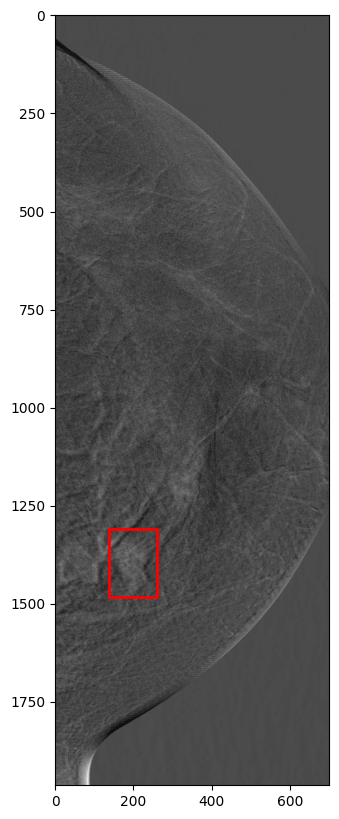

In [52]:
# plot prediction box on top of image_rgb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

image = Image.open(image_path)
topLeftX = out.pred_boxes.tensor[0][0]
topLeftY = out.pred_boxes.tensor[0][1]
bottomRightX = out.pred_boxes.tensor[0][2]
bottomRightY = out.pred_boxes.tensor[0][3]

bbox = patches.Rectangle((topLeftX, topLeftY), bottomRightX - topLeftX, bottomRightY - topLeftY,
                        linewidth=2, edgecolor='r', facecolor='none')

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(image, cmap='gray')
ax.add_patch(bbox)
plt.show()


## Feature extraction

In [3]:
config_file = str(repo_path / 'data/models/config_trained_R_101_30k.yaml')
model_file = str(repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth')
min_score = 0.01 # minimum score to keep prediction

# load trained network 
cfg = get_cfg()
cfg.merge_from_file(config_file)
#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = model_file
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score #0.8  # set the testing threshold for this model
#Pass the validation dataset
# cfg.DATASETS.TEST = ("DBT_train", )
predictor = DefaultPredictor(cfg)
# test_metadata = MetadataCatalog.get("DBT_train")

# read png
image_path = '/home/ricardo/projects/Added_value_feature_uncertainty/deep/data/Pat_example.png'
image_rgb = cv2.imread(image_path)

image_rgb.shape

(1964, 700, 3)

Original prediction pipeline

In [4]:
with torch.no_grad():
    height, width = image_rgb.shape[:2]
    image = predictor.aug.get_transform(image_rgb).apply_image(image_rgb)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = {"image": image, "height": height, "width": width}
    predictions = predictor.model([inputs])[0]
predictions

/home/ricardo/miniconda3/envs/cedm-deep/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


{'instances': Instances(num_instances=1, image_height=1964, image_width=700, fields=[pred_boxes: Boxes(tensor([[ 137.5898, 1310.6466,  258.8565, 1484.4774]], device='cuda:0')), scores: tensor([0.0106], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}

Backbone full-image feature extraction

The Pyramyd feature extraction method gives 5 pyramid levels.<br>
Each level has 256 channels.<br>
Naturally, the shape of the feature maps is decreased with each level.<br>

In [5]:
# backbone feature extraction
with torch.no_grad():
    height, width = image_rgb.shape[:2]
    image = predictor.aug.get_transform(image_rgb).apply_image(image_rgb)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = {"image": image, "height": height, "width": width}
    images = predictor.model.preprocess_image([inputs]) # additional preprocessing step

    feature_maps = predictor.model.backbone(images.tensor)

print(f'The number of feature pyramid levels is {len(feature_maps)} with key {feature_maps.keys()}')
print(f'Each pyramid level has from {feature_maps["p2"].shape} to {feature_maps["p6"].shape} features (aka 256 feature maps of diff shape).')

The number of feature pyramid levels is 5 with key dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])
Each pyramid level has from torch.Size([1, 256, 336, 120]) to torch.Size([1, 256, 21, 8]) features (aka 256 feature maps of diff shape).


Examples of the feature maps

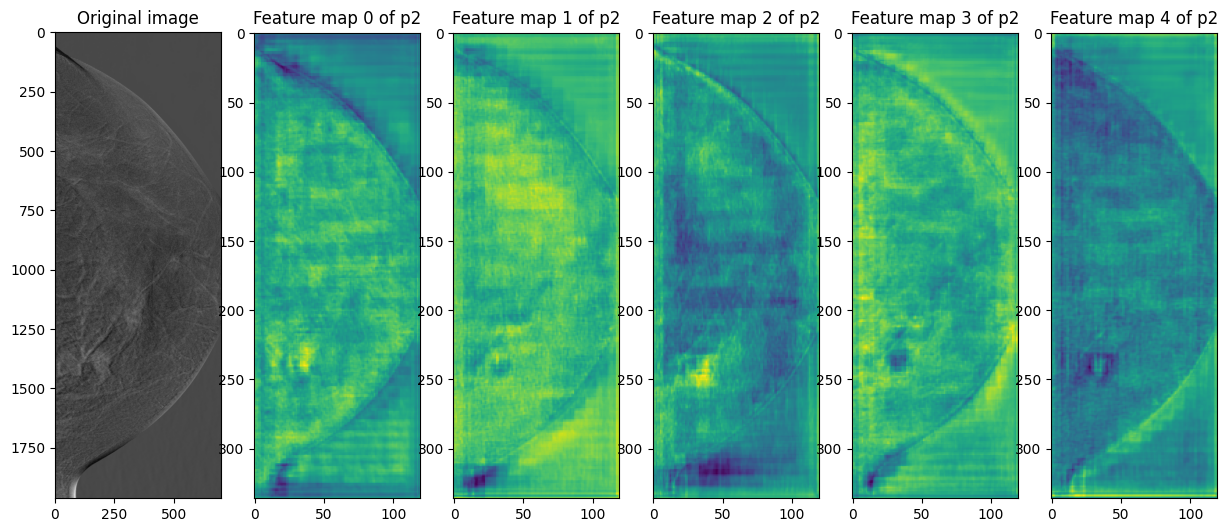

In [6]:
# plot original and n feature maps
map_key = list(feature_maps.keys())[0]
maps_n = 5
fig, ax = plt.subplots(1, maps_n+1, figsize=(15, 10))
ax[0].imshow(image_rgb, cmap='gray')
ax[0].set_title('Original image')
for n in range(maps_n):
    ax[n+1].imshow(feature_maps[map_key][0, -n].detach().cpu().numpy())
    ax[n+1].set_title(f'Feature map {n} of {map_key}')

Proposal examples

tensor([  81.7304,  888.2281,  178.4274, 1011.7986])
tensor([  98.7897,  865.2949,  179.8772, 1025.2357])
tensor([ 74.3757, 869.4557, 184.8210, 997.5395])
tensor([  28.3634,   96.2500,  425.2847, 1026.2699])
tensor([100.6238, 910.9933, 171.1440, 997.9444])
tensor([ 53.5310, 834.9228, 184.7160, 998.4191])
tensor([  82.2673,  815.3731,  177.3322, 1015.3264])
tensor([120.6445, 279.2765, 340.3954, 820.4027])
tensor([147.5909, 254.8159, 358.1661, 725.6609])
tensor([ 118.4421,   67.2645,  467.6201, 1063.1392])
tensor([  3.7249,   0.0000, 381.6250, 894.2023])
tensor([ 267.4808,  425.0782,  475.0000, 1007.2474])
tensor([ 64.8083, 266.7369, 283.8021, 778.1495])
tensor([193.7946, 277.6096, 373.2638, 806.8917])
tensor([109.3115, 262.6556, 309.2173, 705.1437])
tensor([186.0396, 363.0765, 395.2268, 880.3966])
tensor([ 50.3583, 358.8561, 294.5969, 891.5791])
tensor([  0.0000, 207.7534, 411.3792, 781.7816])
tensor([ 70.2902, 186.1150, 261.1320, 714.1370])
tensor([ 194.1359,  262.0916,  475.0000, 1175

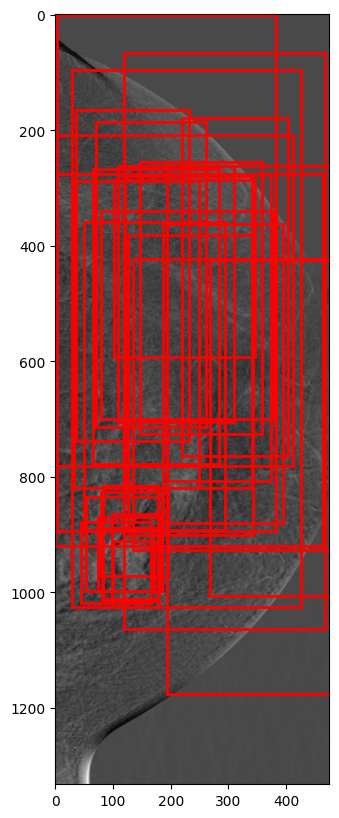

In [7]:
proposals,_ = predictor.model.proposal_generator(images, feature_maps, None)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(image[0], cmap='gray')
for i in range(30):
    proposal_ex = proposals[0].proposal_boxes.tensor[i].detach().cpu()
    bbox_ex = bbox_creation(proposal_ex)
    ax.add_patch(bbox_ex)
    print(proposal_ex)

plt.show()

Final ROI head

Analysis of ROI head part<br>
- It seems that the _forward_box function is the only needed function as the result remains the same after the other function.

In [378]:
pred_instances = predictor.model.roi_heads._forward_box(feature_maps, proposals)
print(pred_instances)
pred_instances = predictor.model.roi_heads.forward_with_given_boxes(feature_maps, pred_instances)
print(pred_instances)

[Instances(num_instances=1, image_height=1333, image_width=475, fields=[pred_boxes: Boxes(tensor([[  93.3645,  889.5580,  175.6526, 1007.5400]], device='cuda:0',
       grad_fn=<IndexBackward>)), scores: tensor([0.0106], device='cuda:0', grad_fn=<IndexBackward>), pred_classes: tensor([0], device='cuda:0')])]
[Instances(num_instances=1, image_height=1333, image_width=475, fields=[pred_boxes: Boxes(tensor([[  93.3645,  889.5580,  175.6526, 1007.5400]], device='cuda:0',
       grad_fn=<IndexBackward>)), scores: tensor([0.0106], device='cuda:0', grad_fn=<IndexBackward>), pred_classes: tensor([0], device='cuda:0')])]


In [379]:
predictor.model.roi_heads

StandardROIHeads(
  (box_pooler): ROIPooler(
    (level_poolers): ModuleList(
      (0): ROIAlign(output_size=(7, 7), spatial_scale=0.25, sampling_ratio=0, aligned=True)
      (1): ROIAlign(output_size=(7, 7), spatial_scale=0.125, sampling_ratio=0, aligned=True)
      (2): ROIAlign(output_size=(7, 7), spatial_scale=0.0625, sampling_ratio=0, aligned=True)
      (3): ROIAlign(output_size=(7, 7), spatial_scale=0.03125, sampling_ratio=0, aligned=True)
    )
  )
  (box_head): FastRCNNConvFCHead(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=12544, out_features=1024, bias=True)
    (fc_relu1): ReLU()
    (fc2): Linear(in_features=1024, out_features=1024, bias=True)
    (fc_relu2): ReLU()
  )
  (box_predictor): FastRCNNOutputLayers(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=4, bias=True)
  )
)

Forward box

First, the original feature maps are reduced into 7x7 256 feature maps, one for each proposal.

The feature maps from the pyramid used are: ['p2', 'p3', 'p4', 'p5']
The regions have been reduced to torch.Size([1000, 256, 7, 7]) feature maps with the box_pooler


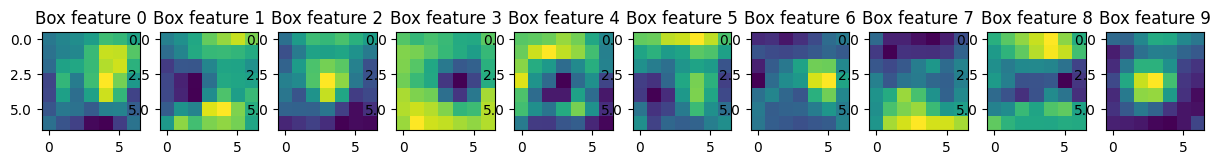

In [87]:
print(f'The feature maps from the pyramid used are: {predictor.model.roi_heads.box_in_features}')
features = [feature_maps[f] for f in predictor.model.roi_heads.box_in_features]
box_features = predictor.model.roi_heads.box_pooler(features, [x.proposal_boxes for x in proposals])
print(f'The regions have been reduced to {box_features.shape} feature maps with the box_pooler')
# show box features
box_feature_n = 10
fig, ax = plt.subplots(1, box_feature_n, figsize=(15, 10))
for n in range(box_feature_n):
    ax[n].imshow(box_features[0, n].detach().cpu().numpy())
    ax[n].set_title(f'Box feature {n}')

Then the head is used to compact the features even further into 1024 features vector. Now each proposal has JUST one 1D-VECTOR.<br>
The final prediction comes from the final layer that used the 1024 features vector as input and gives:
1. A score of the object and the background, one for each proposal.
2. A bbox delta value, one for each proposal.

The final prediction is obtained by using the score to select the best proposal (or proposals?) and then using the bbox delta to adjust the bbox of the proposal.

In [381]:
box_features_after_head = predictor.model.roi_heads.box_head(box_features)
print(box_features_after_head.shape)
predictions = predictor.model.roi_heads.box_predictor(box_features_after_head)
print(predictions)

torch.Size([1000, 1024])
(tensor([[ -2.4550,   2.5711],
        [ -2.5457,   2.6346],
        [ -2.9961,   2.9387],
        ...,
        [ -7.9159,   7.9269],
        [ -7.9395,   7.9819],
        [-11.0021,  10.9625]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([[ 0.5790, -0.2380, -0.9356,  0.0240],
        [-0.6816,  0.0873,  0.1676, -1.2255],
        [ 0.2644,  0.9388, -1.1767, -0.0022],
        ...,
        [ 0.5101, -0.1503, -0.3343,  0.7519],
        [ 0.6082, -0.4086, -0.5246,  0.6439],
        [-0.5448, -0.2077,  0.1779,  0.0603]], device='cuda:0',
       grad_fn=<AddmmBackward>))


tensor([  93.3645,  889.5580,  175.6526, 1007.5400])


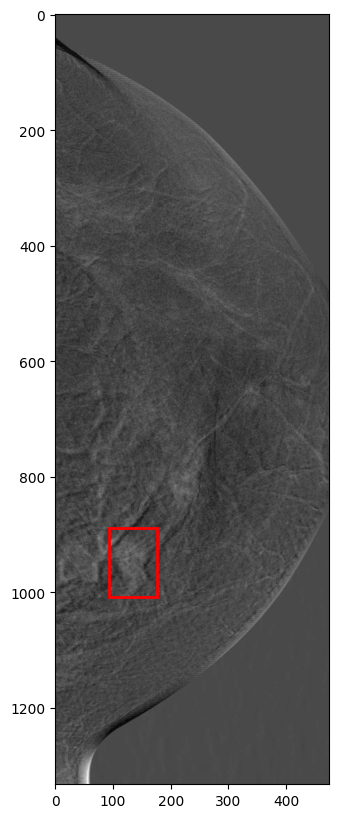

In [382]:
### Notes about the roi_heads
# the roi_heads function does not actually use the images input, it is deleted in the function
# it use a StandardROIheads
results, _ = predictor.model.roi_heads(images, feature_maps, proposals, None)
#show image and results
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(image[0], cmap='gray')
result_ex = results[0].pred_boxes.tensor.detach().cpu()[0]
bbox_ex = bbox_creation(result_ex)
ax.add_patch(bbox_ex)
print(result_ex)
plt.show()

At the ned, we have several places were we can extarct features:

1. Backbone-level full-field features
    - This information is quite general but may be useful.
    - Problems:
        - 5 levels of pyramid, which one to pick?
        - The size of the feature maps on each level changes depeding on the input, how to solve? Same size for all images? Limits the input size.
        - If full field is used, there is no use of the rad segmentation <-not a chance
        - A solution could be directly extracting the features from the radiologist ROI, but again the size of the ROI changes so the feature maps will have different sizes.
        - How is the ROI used? Maybe send to zero all pixels outside the ROI?
    

2. Backbone-level using ROI head pooler
    - More tailored information for the bbox
    - The original 5 levels are combined into one single feature map: 256 channels and 7x7 size (12544 features)
    - The size of the feature vector is always the same.
    - Problems:
        - The ROI bbox is used, not the ROI delination so the features are not exactly following the radiologist detailed ROI.
        - At this point, the ROI delination information cannot directly be used, can it?
            - Solution: Use the ROI delinition over the feature maps before combination, so that only the pixel inside (or around?) the ROI are used. Then combine the feature maps into one single feature map. (Experimental)
        - The number of features is quite high (12544), maybe too high for the final classification.

3. Backbone-level using ROI head pooler AND box head
    - The same as before but the final feature vector is reduced to 1024 features.
    - Solves the problem of the high number of features.
    - Problems:
        - If the ROI delination is used, we still do not know if the information will make sense. (Experimental)

4. Usual feature extraction: backbone layers
    - Select a layer from the FPN backbone network and use it as feature extractor.
    - To use if the others fail.


# Extraction using a given bbox

Setting general model

In [43]:
config_file = str(repo_path / 'data/models/config_trained_R_101_30k.yaml')
model_file = str(repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth')
min_score = 0.01 # minimum score to keep prediction

# load trained network 
cfg = get_cfg()
cfg.merge_from_file(config_file)
#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = model_file
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score #0.8  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

# read png
image_path = '/home/ricardo/projects/Added_value_feature_uncertainty/deep/data/Pat_example.png'
image_rgb = cv2.imread(image_path)

Give bbox. In this case we use the model just to give an example.

In [45]:
with torch.no_grad():
    height, width = image_rgb.shape[:2]
    image = predictor.aug.get_transform(image_rgb).apply_image(image_rgb)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = {"image": image, "height": height, "width": width}
    predictions = predictor.model([inputs])[0]

bbox_lesion = predictions['instances'].pred_boxes.tensor.detach().cpu().numpy()[0]
print(bbox_lesion)

[ 137.5898  1310.6466   258.85654 1484.4774 ]


In [46]:
# we make the bbox match the format of the backbone

from detectron2.structures import Boxes

# transform bbox to the format of the backbone
new_bbox_lesion = predictor.aug.get_transform(image_rgb).apply_box([bbox_lesion])
new_bbox_lesion = torch.as_tensor(new_bbox_lesion).cuda()
# transform to boxes object
new_bbox_lesion = Boxes(new_bbox_lesion)

We do the pyramid feature extraction

In [47]:
# backbone feature extraction
with torch.no_grad():
    height, width = image_rgb.shape[:2]
    image = predictor.aug.get_transform(image_rgb).apply_image(image_rgb)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = {"image": image, "height": height, "width": width}
    images = predictor.model.preprocess_image([inputs]) # additional preprocessing step

    feature_maps = predictor.model.backbone(images.tensor)

print(f'The number of feature pyramid levels is {len(feature_maps)} with key {feature_maps.keys()}')
print(f'Each pyramid level has from {feature_maps["p2"].shape} to {feature_maps["p6"].shape} features (aka 256 feature maps of diff shape).')

The number of feature pyramid levels is 5 with key dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])
Each pyramid level has from torch.Size([1, 256, 336, 120]) to torch.Size([1, 256, 21, 8]) features (aka 256 feature maps of diff shape).


Next, we perform the bbox pooler extraction

The regions have been reduced to torch.Size([1, 256, 7, 7]) feature maps with the box_pooler


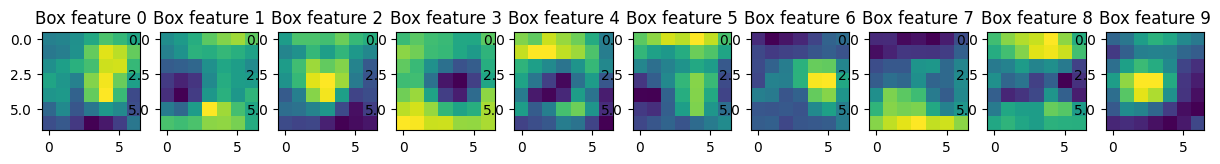

In [48]:
features = [feature_maps[f] for f in predictor.model.roi_heads.box_in_features]
box_features = predictor.model.roi_heads.box_pooler(features, [new_bbox_lesion])
print(f'The regions have been reduced to {box_features.shape} feature maps with the box_pooler')
# show box features
box_feature_n = 10
fig, ax = plt.subplots(1, box_feature_n, figsize=(15, 10))
for n in range(box_feature_n):
    ax[n].imshow(box_features[0, n].detach().cpu().numpy())
    ax[n].set_title(f'Box feature {n}')

Finally we reduce to 1024 feature vector

In [49]:
box_features_after_head = predictor.model.roi_heads.box_head(box_features)
print(box_features_after_head)

tensor([[0.0000, 0.0000, 0.2810,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)


In [50]:
# count number of zero elements in the tensor
print(f'The number of zero elements in the tensor is {torch.sum(box_features_after_head==0)}')
print(f'The number of non-zero elements in the tensor is {torch.sum(box_features_after_head!=0)}')

The number of zero elements in the tensor is 567
The number of non-zero elements in the tensor is 457


Text(0.5, 1.0, 'Feature vector values')

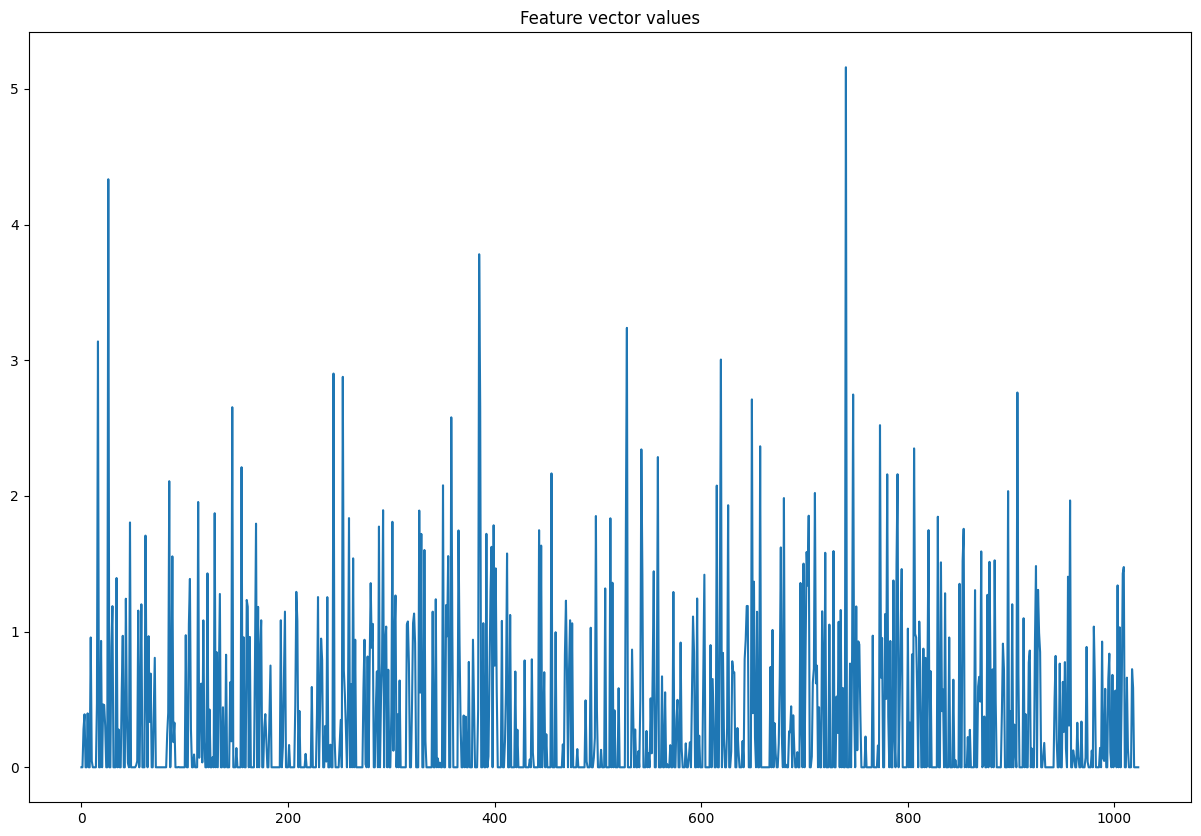

In [51]:
feature_vector = box_features_after_head.detach().cpu().numpy()
# graph the feature vector values
plt.figure(figsize=(15, 10))
plt.plot(feature_vector[0])
plt.title('Feature vector values')